In [2]:
import seaborn as sns
import pandas as pd
import datetime as dt

%config InlineBackend.figure_format='retina'

In [3]:
df = pd.read_parquet("dozzle.parquet")
df["UserID"] = pd.util.hash_array(df["RemoteIP"].to_numpy())
df.drop(
    [
        "RemoteIP",
        "HasHostname",
        "FilterLength",
        "HasDocumentation",
        "Clients",
        "HasActions",
        "Browser",
        "HasCustomBase",
        "HasCustomAddress",
    ],
    axis=1,
    inplace=True,
)

In [4]:
df["activated"] = df.groupby("UserID")["CreatedAt"].transform("min")
df["activated_week"] = (
    df["activated"].dt.isocalendar().year * 52 + df["activated"].dt.isocalendar().week
)
df["current_week"] = (
    df["CreatedAt"].dt.isocalendar().year * 52 + df["CreatedAt"].dt.isocalendar().week
)
df["cohort_index"] = df["current_week"] - df["activated_week"]

<Axes: xlabel='cohort_index'>

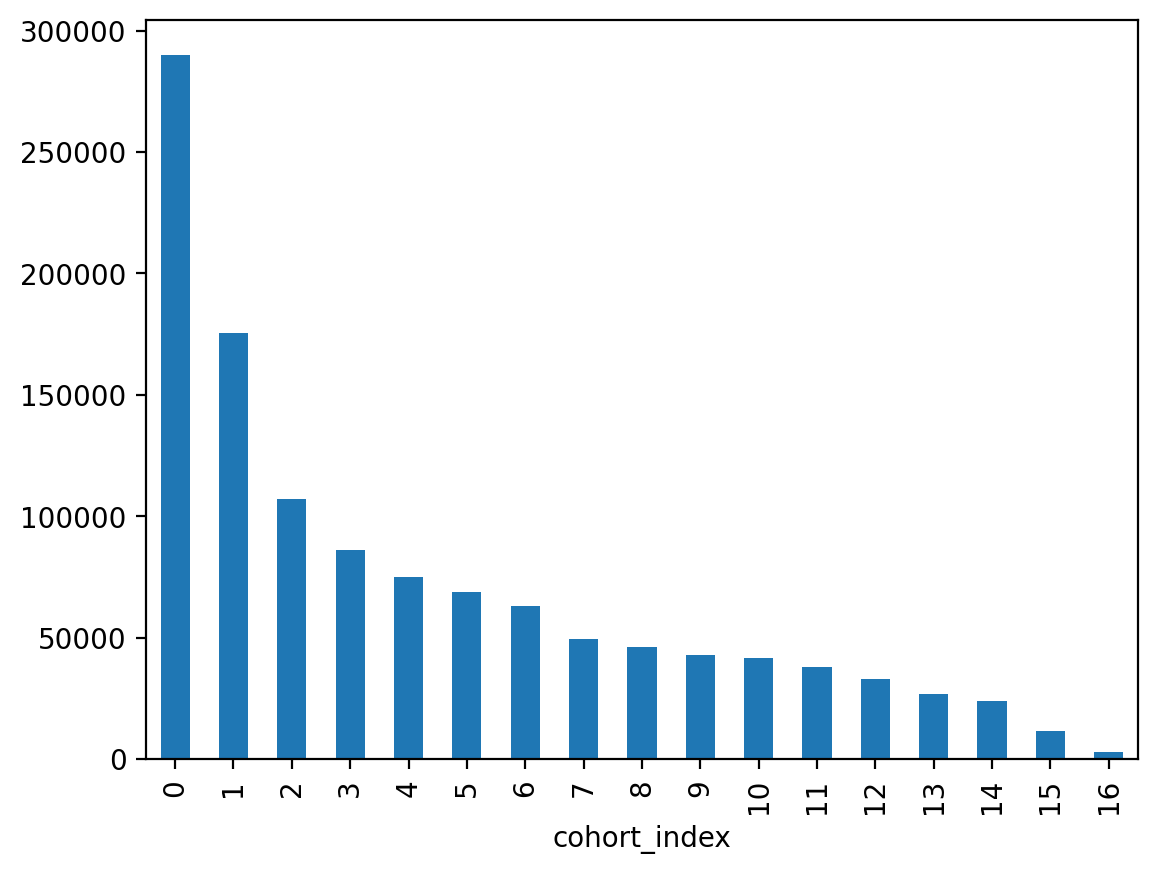

In [5]:
df["cohort_index"].value_counts().sort_index().plot(kind="bar")

In [7]:
cohort_counts = df.groupby(["activated_week", "cohort_index"])["UserID"].nunique()
cohort_counts_df = (
    cohort_counts.to_frame()
    .rename(columns={"UserID": "users"})
    .sort_values(by=["activated_week"])
)
cohort_counts_df["retention_rate"] = cohort_counts_df[
    "users"
] / cohort_counts_df.groupby(["activated_week"])["users"].transform("max")
cohort_counts_df["activated_date"] = cohort_counts_df.index.get_level_values(0).map(
    lambda x: dt.datetime.strptime(f"{int(x/52)}-{x % 52}-1", "%Y-%W-%w").strftime(
        "%Y-%m-%d"
    )
)
cohort_counts_df = (
    cohort_counts_df.reset_index()
    .set_index(["activated_date", "cohort_index"])
    .drop(["activated_week"], axis=1)
)
cohorts_pivot = cohort_counts_df.pivot_table(
    index="activated_date", columns="cohort_index", values="retention_rate"
)

cohort_index,0,1,2,3,4,5,6,7
activated_date,,,,,,,,
2023-11-27,1.0,0.635123,0.492266,0.443130,0.393085,0.417652,0.393995,0.377616
2023-12-04,1.0,0.425897,0.322543,0.265601,0.273011,0.276521,0.261310,0.248830
2023-12-11,1.0,0.345542,0.224578,0.225060,0.214458,0.204819,0.181687,0.172530
2023-12-18,1.0,0.290152,0.218054,0.186987,0.172919,0.142438,0.142438,0.131887
2024-01-01,1.0,0.306299,0.191226,0.162411,0.137064,0.128983,0.115169,0.108324
2024-01-08,1.0,0.298647,0.195630,0.165453,0.132154,0.113944,0.112903,0.119667
2024-01-15,1.0,0.309367,0.211646,0.176203,0.145823,0.131139,0.125570,0.110886
2024-01-22,1.0,0.310451,0.202357,0.166496,0.136270,0.122439,0.112193,0.102459
2024-01-29,1.0,0.279773,0.184783,0.167297,0.134216,0.123346,0.107278,0.071361


<Axes: xlabel='cohort_index', ylabel='activated_date'>

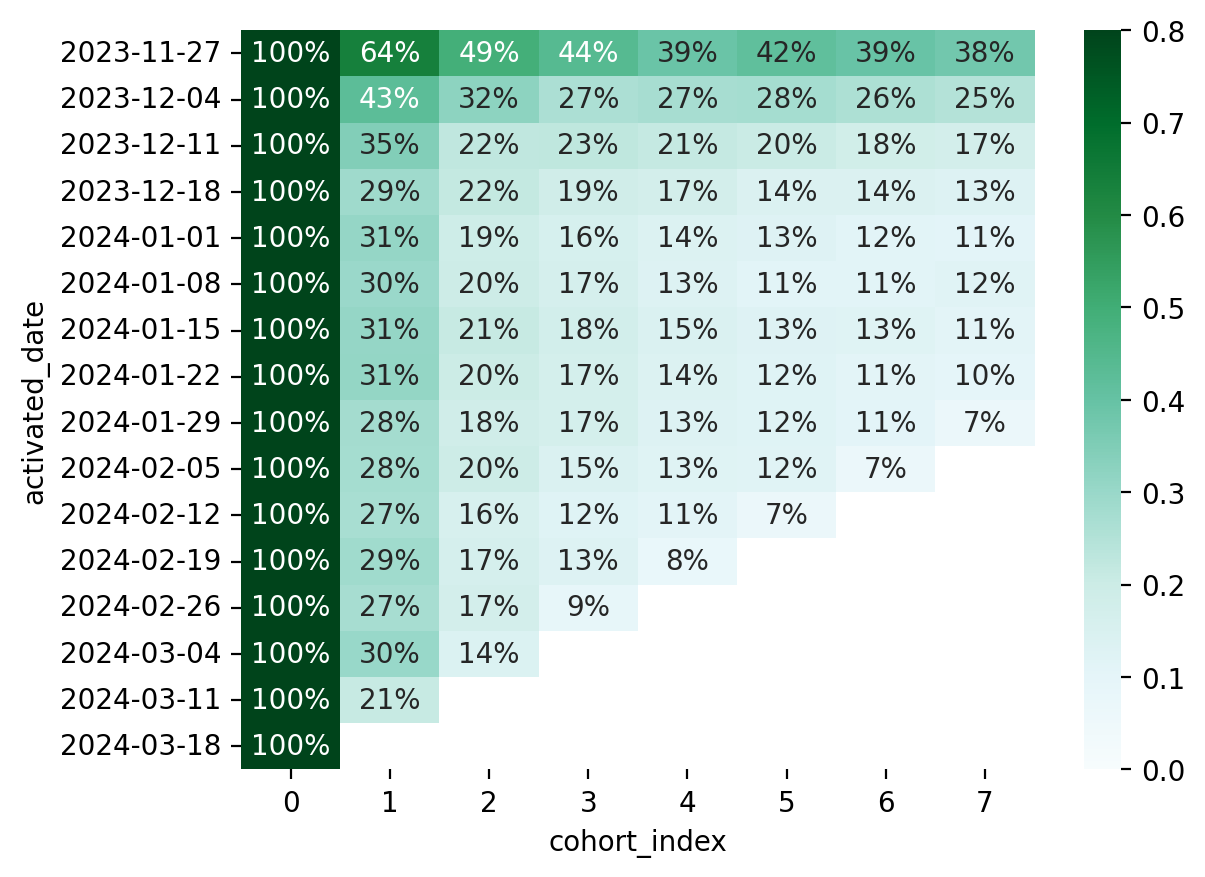

In [8]:
sns.heatmap(
    data=cohorts_pivot[range(8)], annot=True, fmt=".0%", vmin=0.0, vmax=0.8, cmap="BuGn"
)